In [20]:
import nibabel as nib
import numpy as np
import open3d as o3d
from skimage import measure

def nifti_vers_stl(chemin_nifti, chemin_stl, seuil=0.5):
    # Charger l'image NIfTI
    img = nib.load(chemin_nifti)
    volume = img.get_fdata()

    # Extraire la surface avec Marching Cubes
    verts, faces, normals, _ = measure.marching_cubes(volume, level=seuil)

    # Créer un maillage triangulaire
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    # Sauvegarder directement en STL
    o3d.io.write_triangle_mesh(chemin_stl, mesh)
    print(f"Fichier STL sauvegardé : {chemin_stl}")

# Exemple d'utilisation
nifti_vers_stl('label.nii', 'output_slice_label.stl', seuil=0.5)


Fichier STL sauvegardé : output_slice_label.stl


(768, 768, 250)


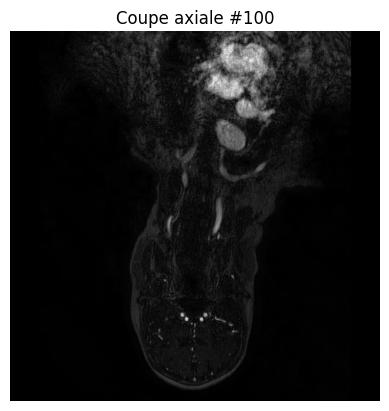

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image NIfTI
img = nib.load('slice.nii')
data = img.get_fdata()

# Vérifier les dimensions
print(data.shape)  # Exemple : (X, Y, Z)

# Extraire une coupe spécifique
# Exemple : coupe numéro 100 dans la troisième dimension (vue axiale)
numero_coupe = 100
coupe_axiale = data[:, :, numero_coupe]

# Afficher la coupe
plt.imshow(coupe_axiale.T, cmap='gray', origin='lower')
plt.title(f'Coupe axiale #{numero_coupe}')
plt.axis('off')
plt.savefig('slice_2.png')
plt.show()

In [22]:
import nibabel as nib

# Charger le fichier NIfTI
img = nib.load('label.nii')

# Afficher l'en-tête
print(img.header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 768 768 250   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.49479166 0.49479166 0.49999723 0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.005963025
quatern_c       : 0.62483966
quatern_d       

In [23]:
import nibabel as nib
import numpy as np
import open3d as o3d
from skimage import measure

def marching_cubes_et_poisson(chemin_nifti, chemin_sortie, seuil=0.5, profondeur=8):
    # Charger le fichier NIfTI
    img = nib.load(chemin_nifti)
    data = img.get_fdata()

    # Marching Cubes : extraire la surface au seuil donné
    verts, faces, normals, _ = measure.marching_cubes(data, level=seuil)

    # Créer un nuage de points avec normales
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(verts)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    # Reconstruction de Poisson
    mesh_poisson, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=profondeur)

    # Calcul des normales pour le mesh final
    mesh_poisson.compute_vertex_normals()

    # Sauvegarder le maillage
    o3d.io.write_triangle_mesh(chemin_sortie, mesh_poisson)
    print(f"Maillage lissé sauvegardé : {chemin_sortie}")

# Exemple d'utilisation
marching_cubes_et_poisson('label.nii', 'output_poisson.stl', seuil=0.5, profondeur=8)


Maillage lissé sauvegardé : output_poisson.stl


[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 1


In [24]:
import open3d as o3d
import nibabel as nib
import numpy as np

def appliquer_affine_sur_maillage(chemin_mesh, chemin_nifti, chemin_sortie):
    # Charger le maillage STL
    maillage = o3d.io.read_triangle_mesh(chemin_mesh)
    maillage.compute_vertex_normals()

    # Charger l'affine du fichier NIfTI
    img = nib.load(chemin_nifti)
    affine = img.affine

    # Appliquer l'affine : rotation + échelle + translation
    sommets = np.asarray(maillage.vertices)
    
    # Ajouter une colonne de 1 pour passer en coordonnées homogènes
    sommets_homogenes = np.hstack([sommets, np.ones((sommets.shape[0], 1))])
    
    # Transformer les sommets
    sommets_transformes = (affine @ sommets_homogenes.T).T[:, :3]
    
    # Mettre à jour les sommets du maillage
    maillage.vertices = o3d.utility.Vector3dVector(sommets_transformes)

    # Sauvegarder le maillage corrigé
    o3d.io.write_triangle_mesh(chemin_sortie, maillage)
    print(f"Maillage corrigé sauvegardé : {chemin_sortie}")

# Exemple d'utilisation
appliquer_affine_sur_maillage('output_poisson.stl', 'label.nii', 'output_poisson_corrected.stl')

Maillage corrigé sauvegardé : output_poisson_corrected.stl


In [25]:
import nibabel as nib
import numpy as np

def afficher_infos_affine(nifti_path):
    # Charger l'image NIfTI
    img = nib.load(nifti_path)
    affine = img.affine

    print("Matrice affine 4x4 :")
    print(affine)

    # Extraire la rotation + échelle (3x3) et la translation (3,)
    rotation_echelle = affine[:3, :3]
    translation = affine[:3, 3]

    # Séparer rotation pure et échelle
    echelles = np.linalg.norm(rotation_echelle, axis=0)
    rotation_pure = rotation_echelle / echelles

    print("\nÉchelle (taille voxel mm) :")
    print(echelles)

    print("\nMatrice de rotation (orientation) :")
    print(rotation_pure)

    print("\nTranslation (position de l'origine en mm) :")
    print(translation)

# Exemple d'utilisation
afficher_infos_affine('label.nii')


Matrice affine 4x4 :
[[-4.80552912e-01  9.51513946e-02  7.02577308e-02  1.50942398e+02]
 [-8.77771527e-02 -9.42304209e-02 -4.82765198e-01  1.36488388e+02]
 [-7.86311626e-02 -4.76325125e-01  1.09539233e-01  1.56798843e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Échelle (taille voxel mm) :
[0.49479166 0.49479166 0.49999723]

Matrice de rotation (orientation) :
[[-0.97122274  0.19230598  0.14051624]
 [-0.17740225 -0.19044464 -0.96553575]
 [-0.15891772 -0.96267816  0.21907968]]

Translation (position de l'origine en mm) :
[150.94239807 136.48838806 156.79884338]


In [2]:
import open3d as o3d
import numpy as np

def rotation_z_180(stl_entree, stl_sortie):
    # Charger le maillage STL
    mesh = o3d.io.read_triangle_mesh(stl_entree)
    mesh.compute_vertex_normals()

    # Matrice de rotation 180° autour de Z
    angle = np.pi  # 180 degrés en radians
    rotation_z = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,             1]
    ])

    # Appliquer la rotation
    mesh.rotate(rotation_z, center=(0, 0, 0))

    # Sauvegarder le mesh tourné
    o3d.io.write_triangle_mesh(stl_sortie, mesh)
    print(f"Maillage tourné sauvegardé : {stl_sortie}")

# Exemple d'utilisation
rotation_z_180("output_poisson_corrected.stl", "output_rotated_z.stl")


Maillage tourné sauvegardé : output_rotated_z.stl
